In [104]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report


In [105]:
df = pd.read_csv('PNS_cleaned.csv')
# df = pd.read_csv('In-Progress_cleaned.csv')
# df = pd.read_csv('Complete_cleaned.csv')

# df.columns.tolist()

In [106]:
df = df[[
    'failure', 
    'project_phase_name', 
    'project_budget_amount', 
    # 'total_phase_actual_spending_amount', 
    # 'over_budget_amount', 
    # 'over_budget_percentage',
    'borough', 
    # 'start_and_planned_end_diff',
    # 'project_type',
    'project_type_SCA',
    'project_type_CIP',
    'project_type_DIIT',
    'project_type_DOE',
    'project_type_DOES',
    'project_type_DOER',
    'project_type_RESOA',
    'project_type_IEH',
    'project_type_PRE-K',
    'project_type_DCAS',
    'project_type_FAST_TRACK_PROJECTS',
]]
df.fillna(0, inplace=True)

# df['over_budget_percentage'].replace([np.inf, -np.inf], np.nan, inplace=True)
# df.dropna(subset=['over_budget_percentage'], inplace=True)

In [107]:
# Identify non-numeric columns
non_numeric_cols = df.select_dtypes(include=['object']).columns

# Convert non-numeric columns to numeric using one-hot encoding
df = pd.get_dummies(df, columns=non_numeric_cols, drop_first=True)
df.replace({True: 1, False: 0}, inplace=True)


/tmp/ipykernel_56718/1259965533.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)


In [108]:
X = df.drop('failure', axis=1)
y = df['failure']

In [109]:
X.columns.tolist()

['project_budget_amount',
 'project_type_SCA',
 'project_type_CIP',
 'project_type_DIIT',
 'project_type_DOE',
 'project_type_DOES',
 'project_type_DOER',
 'project_type_RESOA',
 'project_type_IEH',
 'project_type_PRE-K',
 'project_type_DCAS',
 'project_type_FAST_TRACK_PROJECTS',
 'project_phase_name_CM,Art,F&E',
 'project_phase_name_Construction',
 'project_phase_name_Design',
 'project_phase_name_F&E',
 'project_phase_name_Purch & Install',
 'project_phase_name_Scope',
 'borough_brooklyn',
 'borough_manhattan',
 'borough_queens',
 'borough_staten-island']

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape)
print(y_train.shape)

(2132, 22)
(2132,)


In [111]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit SMOTE on the training data and resample
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(X_train_resampled.shape)
print(y_train_resampled.shape)

(3694, 22)
(3694,)


In [112]:
# # Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [113]:
# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       790
           1       0.84      0.98      0.90       124

    accuracy                           0.97       914
   macro avg       0.92      0.97      0.94       914
weighted avg       0.97      0.97      0.97       914



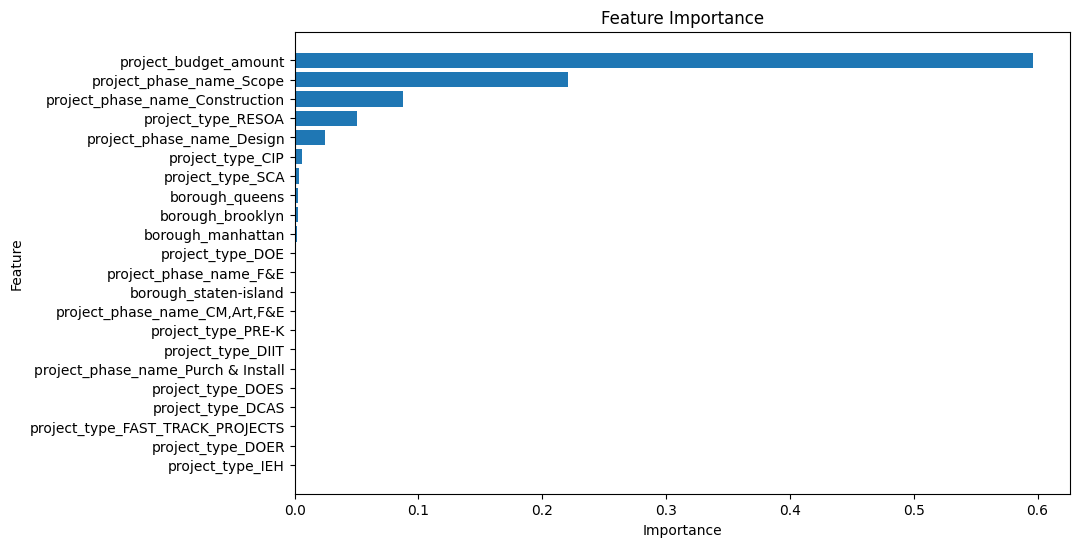

In [114]:
# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [115]:
import shap 
import numpy as np

explainer = shap.Explainer(model, X_train_resampled)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# Convert the SHAP values object to a list of arrays
shap_values_list = [shap_values[:, :, i].values for i in range(shap_values.values.shape[2])]

# Combine the SHAP values for all classes by summing the absolute values across classes
shap_values_combined = np.sum(np.abs(shap_values_list), axis=0)

In [116]:
# shap_values_combined

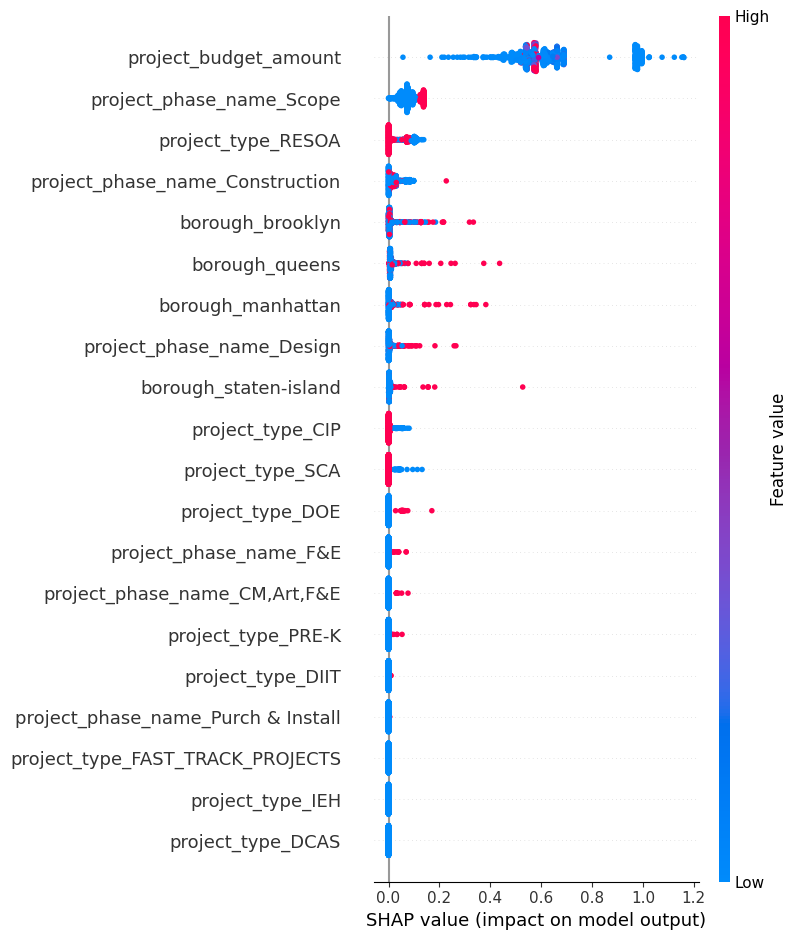

In [117]:
assert shap_values_combined.shape == X_test.shape, "SHAP values and data matrix shapes do not match!"
shap.summary_plot(shap_values_combined, X_test)

Feature Importance based on mean absolute SHAP values:
project_budget_amount                 0.637561
project_phase_name_Scope              0.079504
project_type_RESOA                    0.038528
project_phase_name_Construction       0.024384
borough_brooklyn                      0.012540
borough_queens                        0.012474
borough_manhattan                     0.008325
project_phase_name_Design             0.006751
borough_staten-island                 0.005011
project_type_CIP                      0.004244
project_type_SCA                      0.002570
project_type_DOE                      0.002490
project_phase_name_F&E                0.000461
project_phase_name_CM,Art,F&E         0.000386
project_type_PRE-K                    0.000189
project_type_DIIT                     0.000021
project_phase_name_Purch & Install    0.000009
project_type_DOES                     0.000000
project_type_DCAS                     0.000000
project_type_FAST_TRACK_PROJECTS      0.000000
proje

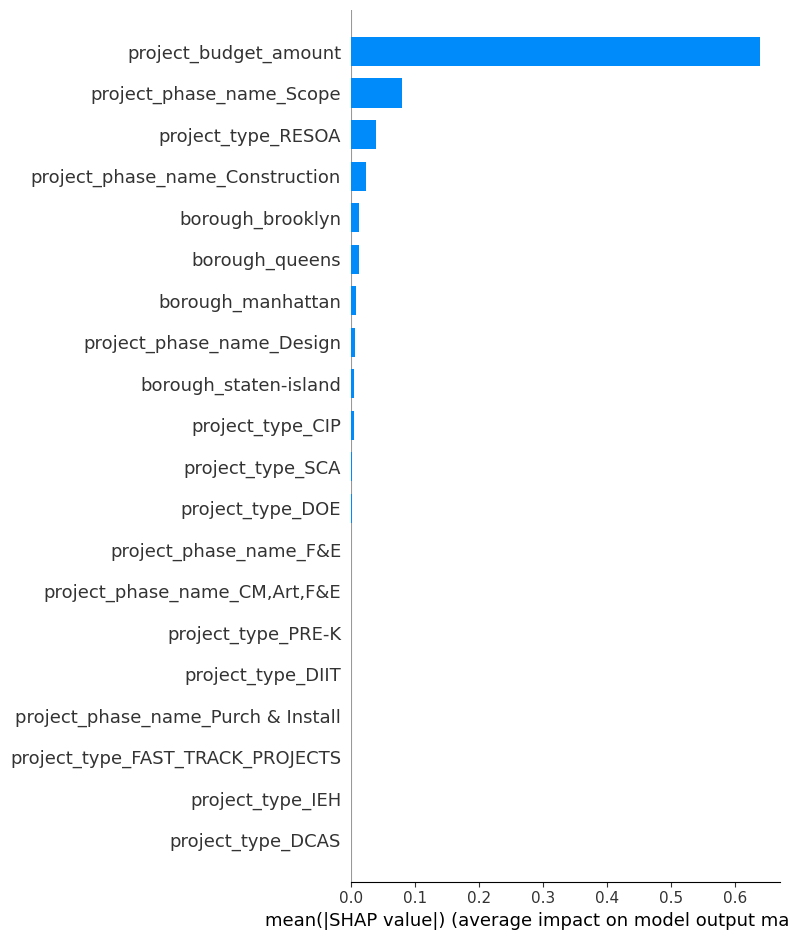

In [121]:
# Compute SHAP values
explainer = shap.Explainer(model, X_train_resampled)
shap_values = explainer(X_test)

# Convert the SHAP values object to a list of arrays
shap_values_list = [shap_values[:, :, i].values for i in range(shap_values.values.shape[2])]

# Combine the SHAP values for all classes by summing the absolute values across classes
shap_values_combined = np.sum(np.abs(shap_values_list), axis=0)

# Assert shapes match
assert shap_values_combined.shape == X_test.shape, "SHAP values and data matrix shapes do not match!"

# Print feature importance based on mean absolute SHAP values
shap_df = pd.DataFrame(shap_values_combined, columns=X_test.columns)
feature_importance_shap = shap_df.abs().mean().sort_values(ascending=False)
print("Feature Importance based on mean absolute SHAP values:")
print(feature_importance_shap)

# Plot SHAP summary
shap.summary_plot(shap_values_combined, X_test, plot_type="bar")

In [118]:
shap.dependence_plot("total_phase_actual_spending_amount", shap_values_combined, X_test, interaction_index="project_phase_name_Construction")

ValueError: Could not find feature named: total_phase_actual_spending_amount

In [ ]:
expected_value = explainer.expected_value

shap.force_plot(
    expected_value,
    shap_values[misclassified],
    features_display[misclassified],
    link="logit",
    matplotlib=True,
)

NameError: name 'misclassified' is not defined